## LSTM 
An LSTM (Long Short-Term Memory) network is a recurrent neural architecture that models ordered sequences with long-range dependencies, making it well suited to our question because it can learn how the temporal pattern of a user’s early interactions (not just their aggregates) predicts whether the user will remain active.

### 1. Imports

In [5]:
# Basic
import numpy as np
import pandas as pd

# Splits & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.utils import class_weight

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### 2. Loading Dataset

In [6]:
df = pd.read_csv("../data/user_level_data.csv")
print("Data loaded.")
print(df.shape)
df.head()

Data loaded.
(20011, 30)


,userId,y_active,province,age_gender_missing,followCnt_log,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,usr_ever_shared,...,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index,entropy_pca
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,2.256350,0.480283,1.180606,48.0,2.267197,-1.697836
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,0.0,0.0,0.0,0,0,...,1,0,0,0,2.165025,1.093763,8.046980,99.5,5.094862,0.607040
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,3.397364,2.701603,1.068558,96.5,3.110704,0.607040
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,0.0,0.0,0.0,0,0,...,1,0,0,0,2.986048,0.246188,0.690819,26.0,1.754418,-1.697836
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,-2.020211,0.186660,0.155593,164.0,-0.820507,-1.697836


### 3. Feature Engineering

In [7]:
# Drop userId
drop_cols = ["userId"] if "userId" in df.columns else []
df = df.drop(columns=drop_cols, errors="ignore")

# Target
TARGET_COL = "y_active"
y = df[TARGET_COL].astype(int).values
X = df.drop(columns=[TARGET_COL])

# Encoding
if "province" in X.columns:
    X = pd.get_dummies(X, columns=["province"], drop_first=True)

feature_names = X.columns.tolist()
print(f"Final number of features: {len(feature_names)}")

Final number of features: 61


### 4. Splitting the data

In [8]:
# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values,
    y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y
)

# Then split train and validation from temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25, 
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (12006, 61)
Val:   (4002, 61)
Test:  (4003, 61)


### 5. Scaling and Reshaping for LSTM
LSTM expects 3D input: (samples, time_steps, features). Since this is user-level data → we set time_steps = 1.

In [9]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# reshape into LSTM format
X_train_seq = np.expand_dims(X_train_s, axis=1)
X_val_seq   = np.expand_dims(X_val_s, axis=1)
X_test_seq  = np.expand_dims(X_test_s, axis=1)

print("LSTM input shape:", X_train_seq.shape)

LSTM input shape: (12006, 1, 61)


### 6. Model Training

In [10]:
# n_features must be defined AFTER X_train_seq exists
n_features = X_train_seq.shape[2]
print("Number of features for LSTM:", n_features)

def build_lstm_model(n_features):
    model = models.Sequential()

    # LSTM layer
    model.add(layers.LSTM(
        64,
        return_sequences=False,
        input_shape=(1, n_features)
    ))

    # Regularization
    model.add(layers.Dropout(0.4))

    # Dense layers
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation="relu"))

    # Output (binary)
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

model = build_lstm_model(n_features)
model.summary()

# Class weights (imbalance)
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
cw = {i: w for i, w in enumerate(cw)}
print("Class weights:", cw)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=5,
    mode="max",
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# Train
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=256,
    class_weight=cw,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Number of features for LSTM: 61
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                32256     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38529 (150

### 7. Validation Performance

In [11]:
val_proba = model.predict(X_val_seq).ravel()

val_auc = roc_auc_score(y_val, val_proba)
val_pr  = average_precision_score(y_val, val_proba)

print("\n============================")
print("VALIDATION RESULTS")
print("============================")
print(f"Val ROC-AUC: {val_auc:.4f}")
print(f"Val PR-AUC:  {val_pr:.4f}")

126/126 [==============================] - 1s 3ms/step

VALIDATION RESULTS
Val ROC-AUC: 0.9253
Val PR-AUC:  0.7826


### 8. Threshold Optimization

In [12]:
# --- ROC curve → Youden J ---
fpr, tpr, thresholds = roc_curve(y_val, val_proba)
youden = tpr - fpr
best_idx = np.argmax(youden)
thr_youden = thresholds[best_idx]

# --- PR curve → F1 ---
precision, recall, pr_thr = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
thr_f1 = pr_thr[np.argmax(f1_scores)]

print("\nOptimal threshold (Youden J):", round(thr_youden, 3))
print("Optimal threshold (F1):       ", round(thr_f1, 3))

# USE F1 threshold
final_threshold = float(thr_f1)


Optimal threshold (Youden J): 0.463
Optimal threshold (F1):        0.549


### 9. Model Evaluation

126/126 [==============================] - 0s 3ms/step

TEST SET PERFORMANCE
Threshold:         0.549
Accuracy:          0.8444
Precision:         0.6585
Recall:            0.9576
F1 Score:          0.7804
ROC-AUC:           0.9258
PR-AUC:            0.7888

Confusion Matrix:
              Inactive (0)  Active (1)
Inactive (0)          2273         574
Active (1)              49        1107


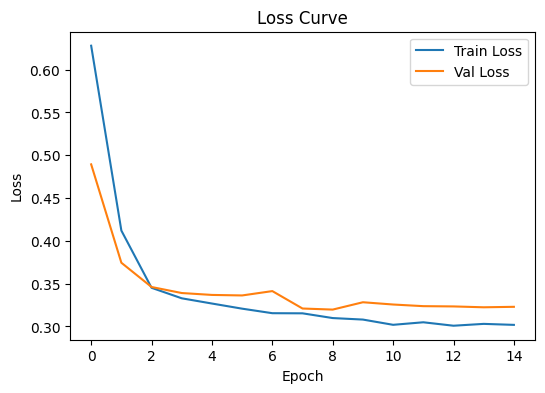

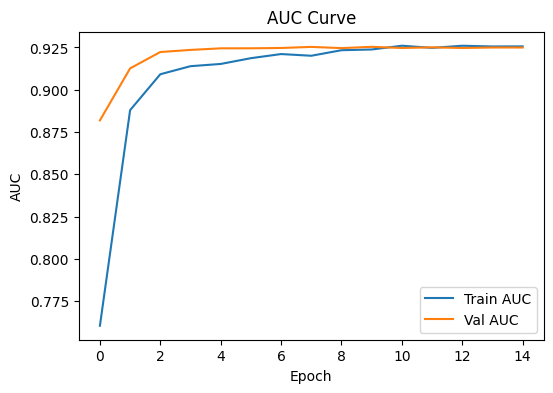

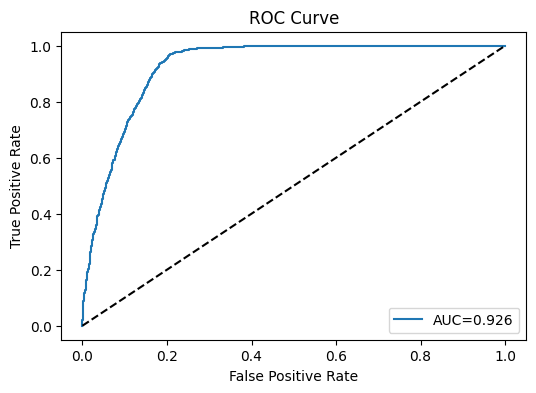

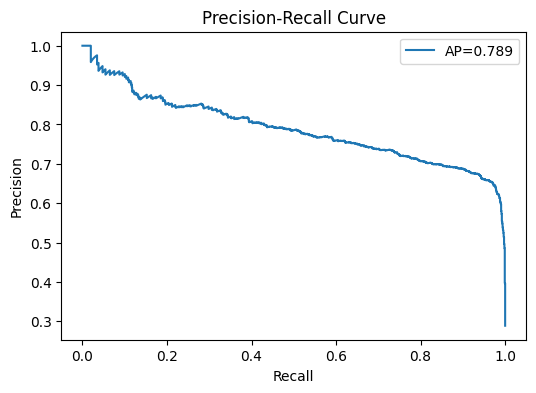

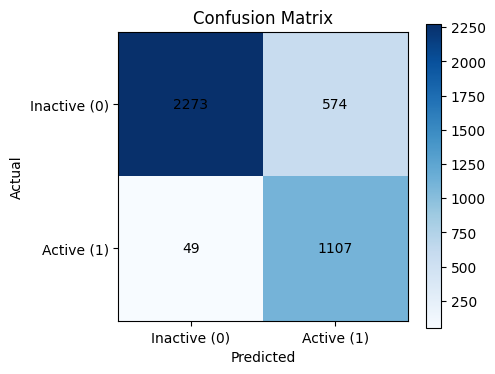


FEATURE IMPORTANCE (PERMUTATION)
126/126 [==============================] - 1s 5ms/step


,feature,importance
26,entropy_pca,0.214973
17,usr_only_click,0.030558
13,usr_avg_dwell,0.011992
21,avg_pop_index_pca,0.010069
11,usr_followlog_x_actionrate,0.004997
2,usr_like_rate,0.004462
15,usr_active_days,0.001750
8,usr_shares_per_exp_follow,0.001633
25,max_creator_pop_index,0.001615
5,usr_ever_inthomeviewed,0.001600


In [13]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

test_proba = model.predict(X_test_seq).ravel()
test_pred  = (test_proba >= final_threshold).astype(int)

# Metrics
test_accuracy  = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred)
test_recall    = recall_score(y_test, test_pred)
test_f1        = f1_score(y_test, test_pred)
test_auc       = roc_auc_score(y_test, test_proba)
test_pr        = average_precision_score(y_test, test_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
cm_labels = ["Inactive (0)", "Active (1)"]

print("\n============================")
print("TEST SET PERFORMANCE")
print("============================")
print(f"Threshold:         {final_threshold:.3f}")
print(f"Accuracy:          {test_accuracy:.4f}")
print(f"Precision:         {test_precision:.4f}")
print(f"Recall:            {test_recall:.4f}")
print(f"F1 Score:          {test_f1:.4f}")
print(f"ROC-AUC:           {test_auc:.4f}")
print(f"PR-AUC:            {test_pr:.4f}")

print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=cm_labels, columns=cm_labels))

# --- Training curves: Loss ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# --- Training curves: AUC ---
plt.figure(figsize=(6,4))
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC Curve")
plt.legend()
plt.show()

# --- ROC curve ---
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr_test, tpr_test, label=f"AUC={test_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- PR curve ---
prec_test, rec_test, _ = precision_recall_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(rec_test, prec_test, label=f"AP={test_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Confusion Matrix Plot ---
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, cm_labels)
plt.yticks(tick_marks, cm_labels)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n============================")
print("FEATURE IMPORTANCE (PERMUTATION)")
print("============================")

def permutation_importance_lstm(model, X_seq, y_true, feature_names, repeats=3):

    baseline_pred = model.predict(X_seq).ravel()
    baseline_score = roc_auc_score(y_true, baseline_pred)

    n_samples, time_steps, n_features = X_seq.shape
    importances = []

    for j in range(n_features):
        scores = []
        for _ in range(repeats):
            X_perm = X_seq.copy()
            perm_idx = np.random.permutation(n_samples)
            X_perm[:, :, j] = X_perm[perm_idx, :, j]

            perm_pred = model.predict(X_perm).ravel()
            score = roc_auc_score(y_true, perm_pred)
            scores.append(score)

        importance = baseline_score - np.mean(scores)
        importances.append(importance)

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    return fi_df

fi_df = permutation_importance_lstm(model, X_test_seq, y_test, feature_names)
fi_df.head(20)
